# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# FashionMNIST 분류 모델 만들기
* 흑/백(1) 이미지 데이터 분류
* 28x28 pixel

## 데이터 로드

In [5]:
# 데이터 전처리

MNIST_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [6]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=MNIST_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=MNIST_transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content\FashionMNIST\raw\train-images-idx3-ubyte.gz to /content\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content\FashionMNIST\raw\train-labels-idx1-ubyte.gz to /content\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /content\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /content\FashionMNIST\raw



input-data size 확인

In [7]:
# batch-size=128
train_loader128 =  DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader128 =  DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# batch-size=64
train_loader64 =  DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader64 =  DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [8]:
# 128 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images128, labels128 = next(iter(train_loader128))
images128.shape, labels128.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
# 64 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images64, labels64 = next(iter(train_loader64))
images64.shape, labels64.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

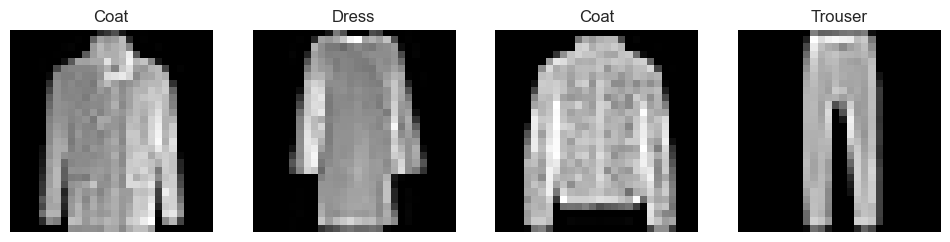

In [11]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images128[i].squeeze()
    label_idx = labels128[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## 모델 1 생성
* 10개의 convolution-layer(Conv2d)와 2개의 fully-connected(fc)로 이루어진 모델
* Total params: 28,784

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* convolution-layer 3
* convolution-layer 4
* convolution-layer 5
* convolution-layer 6
* convolution-layer 7
* convolution-layer 8
* convolution-layer 9
* maxpooling-layer
* convolution-layer 10
* flatten
* fc1
* fc2

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc2에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.
1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 16, 16, 16])
> * torch.Size([128 or 64, 19, 15, 15])
> * torch.Size([128 or 64, 29, 13, 13])
> * torch.Size([128 or 64, 29, 14, 14])
> * torch.Size([128 or 64, 6, 12, 12])
> * torch.Size([128 or 64, 2, 12, 12])
> * torch.Size([128 or 64, 10, 7, 7])
> * torch.Size([128 or 64, 20, 7, 7])
> * torch.Size([128 or 64, 20, 3, 3])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10]) 

In [12]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        # in-channels = 1 <- 흑/백
        # out-channels = 5
        # kernel_size / filter-size = 2x2 -> f=3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 28x28 -> n=28
        # (n-f+2p)/s + 1 = new n
        # (28-3+2x2)/1 + 1 = 30
    
        # maxpool : n=30 -> 15

        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        # in-channels = 5 <- 이전것의 out-channels
        # out-channels = 7
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 1
        # (n-f+2p)/s + 1 = new n    
        # (15-3+2x1)/1 + 1 = 15

        self.conv3 = nn.Conv2d(7, 16, 2, padding = 1)
        # in-channels = 7 <- 이전것의 out-channels
        # out-channels = 16
        # filter-size = 2x2
        # stride = 1(default)
        # padding = 1
        # (15-2+2x1)/1 + 1 = 16

        self.conv4 = nn.Conv2d(16, 19, 2)
        # in-channels = 16 <- 이전것의 out-channels
        # out-channels = 19
        # filter-size = 2x2
        # stride = 1(default)
        # padding = 0
        # (16-2)/1 + 1 = 15

        self.conv5 = nn.Conv2d(19, 29, 3)
        # in-channels = 19 <- 이전것의 out-channels
        # out-channels = 29
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 0
        # (15-3)/1 + 1 = 13

        self.conv6 = nn.Conv2d(29, 29, 2, padding = 1)
        # in-channels = 29 <- 이전것의 out-channels
        # out-channels = 29
        # filter-size = 2x2
        # stride = 1(default)
        # padding = 1
        # (13-2+2x1)/1 + 1 = 14

        self.conv7 = nn.Conv2d(29, 6, 3)
        # in-channels = 29 <- 이전것의 out-channels
        # out-channels = 6
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 0
        # (14-3)/1 + 1 = 12

        self.conv8 = nn.Conv2d(6, 2, 1)
        # in-channels = 6 <- 이전것의 out-channels
        # out-channels = 2
        # filter-size = 1x1
        # stride = 1(default)
        # padding = 0
        # (12-1)/1 + 1 = 12

        self.conv9 = nn.Conv2d(2, 10, 2, 2, 1)
        # in-channels = 2 <- 이전것의 out-channels
        # out-channels = 10
        # filter-size = 2x2
        # stride = 2(default)
        # padding = 1
        # (12-2+2x1)/2 + 1 = 7

        # maxpool 7 -> 3

        self.conv10 = nn.Conv2d(10, 20, 1)
        # in-channels = 10 <- 이전것의 out-channels
        # out-channels = 20
        # filter-size = 1x1
        # stride = 1(default)
        # padding = 0
        # (3-1)/1 + 1 = 3

        self.fc1 = nn.Linear(180, 86)
        self.fc2 = nn.Linear(86, 10)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv10(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [13]:
# 모델객체 생성
DeepConv_net128 = CNN_Model1().to(device)
DeepConv_net64 = CNN_Model1().to(device)

print(DeepConv_net128)

CNN_Model1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(29, 29, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(29, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(6, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(2, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv10): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=180, out_features=86, bias=True)
  (fc2): Linear(in_features=86, out_features=10, bias=True)
)


In [14]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [15]:
output = DeepConv_net128.forward(input)
output.size()

torch.Size([128, 10])

In [16]:
summary(DeepConv_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Conv2d-6          [128, 29, 14, 14]           3,393
            Conv2d-7           [128, 6, 12, 12]           1,572
            Conv2d-8           [128, 2, 12, 12]              14
            Conv2d-9            [128, 10, 7, 7]              90
           Conv2d-10            [128, 20, 3, 3]             220
           Linear-11                  [128, 86]          15,566
           Linear-12                  [128, 10]             870
Total params: 28,784
Trainable params: 28,784
Non-trainable params: 0
---------------------------------

In [17]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [18]:
output = DeepConv_net64.forward(input)
output.size()

torch.Size([64, 10])

In [19]:
summary(DeepConv_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Conv2d-3           [64, 16, 16, 16]             464
            Conv2d-4           [64, 19, 15, 15]           1,235
            Conv2d-5           [64, 29, 13, 13]           4,988
            Conv2d-6           [64, 29, 14, 14]           3,393
            Conv2d-7            [64, 6, 12, 12]           1,572
            Conv2d-8            [64, 2, 12, 12]              14
            Conv2d-9             [64, 10, 7, 7]              90
           Conv2d-10             [64, 20, 3, 3]             220
           Linear-11                   [64, 86]          15,566
           Linear-12                   [64, 10]             870
Total params: 28,784
Trainable params: 28,784
Non-trainable params: 0
---------------------------------

## 모델 2 생성
* 2개의 convolution-layer(Conv2d)와 5개의 fully-connected(fc)로 이루어진 모델
* Total params: 9,516,488

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* flatten
* fc1
* fc2
* fc3
* fc4
* fc5

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc5에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.

1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 1575])
> * torch.Size([128 or 64, 3000])
> * torch.Size([128 or 64, 1500])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10])

In [20]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.fc1 = nn.Linear(1575, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 180)
        self.fc4 = nn.Linear(180, 86)
        self.fc5 = nn.Linear(86, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [21]:
# 모델객체 생성
DeepFC_net128 = CNN_Model2().to(device)
DeepFC_net64 = CNN_Model2().to(device)

print(DeepFC_net128)

CNN_Model2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1575, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [22]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [23]:
output = DeepFC_net128.forward(input)
output.size()

torch.Size([128, 10])

In [24]:
summary(DeepFC_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Linear-3                [128, 3000]       4,728,000
            Linear-4                [128, 1500]       4,501,500
            Linear-5                 [128, 180]         270,180
            Linear-6                  [128, 86]          15,566
            Linear-7                  [128, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 10.60
Params size (MB): 36.30
Estimated Total Size (MB): 47.28
----------------------------------------------------------------


In [25]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [26]:
output = DeepFC_net64.forward(input)
output.size()

torch.Size([64, 10])

In [27]:
summary(DeepFC_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Linear-3                 [64, 3000]       4,728,000
            Linear-4                 [64, 1500]       4,501,500
            Linear-5                  [64, 180]         270,180
            Linear-6                   [64, 86]          15,566
            Linear-7                   [64, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.30
Params size (MB): 36.30
Estimated Total Size (MB): 41.79
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [28]:
criterion = nn.CrossEntropyLoss()

optimizerDC_128 = optim.SGD(DeepConv_net128.parameters(), lr=0.001, momentum=0.9)
optimizerDC_64 = optim.SGD(DeepConv_net64.parameters(), lr=0.001, momentum=0.9)
optimizerFC_128 = optim.SGD(DeepFC_net128.parameters(), lr=0.001, momentum=0.9)
optimizerFC_64 = optim.SGD(DeepFC_net64.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

### 1. DeepConv_net128
* 10개의 Convolution-layer & 2개의 fc-layer
* 128 batch-size

In [29]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11519479739665985
Epoch: 1, Iter: 200, Loss: 0.11519367837905883
Epoch: 1, Iter: 300, Loss: 0.1152034227848053
Epoch: 1, Iter: 400, Loss: 0.11519684958457947
Epoch: 2, Iter: 100, Loss: 0.11514031815528869
Epoch: 2, Iter: 200, Loss: 0.11512505769729614
Epoch: 2, Iter: 300, Loss: 0.11515050435066224
Epoch: 2, Iter: 400, Loss: 0.11515679585933686
Epoch: 3, Iter: 100, Loss: 0.11513321316242218
Epoch: 3, Iter: 200, Loss: 0.11513408744335174
Epoch: 3, Iter: 300, Loss: 0.11513718092441559
Epoch: 3, Iter: 400, Loss: 0.11512928879261017
Epoch: 4, Iter: 100, Loss: 0.11512900936603546
Epoch: 4, Iter: 200, Loss: 0.11513445842266083
Epoch: 4, Iter: 300, Loss: 0.11513011610507964
Epoch: 4, Iter: 400, Loss: 0.11513668262958526
Epoch: 5, Iter: 100, Loss: 0.11513098239898682
Epoch: 5, Iter: 200, Loss: 0.11513238370418549
Epoch: 5, Iter: 300, Loss: 0.11513216161727906
Epoch: 5, Iter: 400, Loss: 0.11513201797008514
Epoch: 6, Iter: 100, Loss: 0.11512924039363862
Epoch: 6, Iter

In [30]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11512964248657226
Epoch: 1, Iter: 200, Loss: 0.11512819361686706
Epoch: 1, Iter: 300, Loss: 0.11513369178771973
Epoch: 1, Iter: 400, Loss: 0.11513620805740356
Epoch: 2, Iter: 100, Loss: 0.11512853741645813
Epoch: 2, Iter: 200, Loss: 0.1151351342201233
Epoch: 2, Iter: 300, Loss: 0.11513287448883057
Epoch: 2, Iter: 400, Loss: 0.1151314880847931
Epoch: 3, Iter: 100, Loss: 0.1151319524049759
Epoch: 3, Iter: 200, Loss: 0.1151317880153656
Epoch: 3, Iter: 300, Loss: 0.11513044595718384
Epoch: 3, Iter: 400, Loss: 0.11513475620746613
Epoch: 4, Iter: 100, Loss: 0.11512965786457062
Epoch: 4, Iter: 200, Loss: 0.11512736403942109
Epoch: 4, Iter: 300, Loss: 0.11513324749469757
Epoch: 4, Iter: 400, Loss: 0.115136115193367
Epoch: 5, Iter: 100, Loss: 0.11512960338592529
Epoch: 5, Iter: 200, Loss: 0.11513108634948731
Epoch: 5, Iter: 300, Loss: 0.11513130187988281
Epoch: 5, Iter: 400, Loss: 0.11513468194007874


### 2. DeepConv_net64
* 10개의 Convolution-layer & 2개의 fc-layer
* 64 batch-size

In [31]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11522074139118195
Epoch: 1, Iter: 200, Loss: 0.11512977814674377
Epoch: 1, Iter: 300, Loss: 0.11517922043800354
Epoch: 1, Iter: 400, Loss: 0.11514819049835205
Epoch: 1, Iter: 500, Loss: 0.11515011107921601
Epoch: 1, Iter: 600, Loss: 0.11514553821086884
Epoch: 1, Iter: 700, Loss: 0.11515444791316987
Epoch: 1, Iter: 800, Loss: 0.11513772022724152
Epoch: 1, Iter: 900, Loss: 0.11513489294052125
Epoch: 2, Iter: 100, Loss: 0.11513527107238769
Epoch: 2, Iter: 200, Loss: 0.11514170241355896
Epoch: 2, Iter: 300, Loss: 0.11513168156147004
Epoch: 2, Iter: 400, Loss: 0.1151385998725891
Epoch: 2, Iter: 500, Loss: 0.11513941311836243
Epoch: 2, Iter: 600, Loss: 0.11513876593112946
Epoch: 2, Iter: 700, Loss: 0.11513182079792023
Epoch: 2, Iter: 800, Loss: 0.11513439977169036
Epoch: 2, Iter: 900, Loss: 0.11514524114131927
Epoch: 3, Iter: 100, Loss: 0.1151345796585083
Epoch: 3, Iter: 200, Loss: 0.1151304132938385
Epoch: 3, Iter: 300, Loss: 0.11513115918636321
Epoch: 3, Iter: 

### 3. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 128 batch-size

In [32]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11521083521842956
Epoch: 1, Iter: 200, Loss: 0.11517211782932281
Epoch: 1, Iter: 300, Loss: 0.1150560292005539
Epoch: 1, Iter: 400, Loss: 0.11503081524372101
Epoch: 2, Iter: 100, Loss: 0.11490645086765289
Epoch: 2, Iter: 200, Loss: 0.11479040157794952
Epoch: 2, Iter: 300, Loss: 0.11462052822113038
Epoch: 2, Iter: 400, Loss: 0.11434726226329804
Epoch: 3, Iter: 100, Loss: 0.11328283393383026
Epoch: 3, Iter: 200, Loss: 0.11140921914577484
Epoch: 3, Iter: 300, Loss: 0.10119562417268753
Epoch: 3, Iter: 400, Loss: 0.06707408291101456
Epoch: 4, Iter: 100, Loss: 0.04089167630672455
Epoch: 4, Iter: 200, Loss: 0.036849745094776155
Epoch: 4, Iter: 300, Loss: 0.034453012347221375
Epoch: 4, Iter: 400, Loss: 0.032814052134752275
Epoch: 5, Iter: 100, Loss: 0.03131876961886883
Epoch: 5, Iter: 200, Loss: 0.030955702006816865
Epoch: 5, Iter: 300, Loss: 0.030682109862565993
Epoch: 5, Iter: 400, Loss: 0.030516548812389376
Epoch: 6, Iter: 100, Loss: 0.028526068583130837
Epoch: 

### 4. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 64 batch-size

In [33]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11517628777027131
Epoch: 1, Iter: 200, Loss: 0.11516560661792755
Epoch: 1, Iter: 300, Loss: 0.1151461582183838
Epoch: 1, Iter: 400, Loss: 0.11508893048763275
Epoch: 1, Iter: 500, Loss: 0.11503263330459594
Epoch: 1, Iter: 600, Loss: 0.11499428164958954
Epoch: 1, Iter: 700, Loss: 0.11496455466747284
Epoch: 1, Iter: 800, Loss: 0.11495530104637146
Epoch: 1, Iter: 900, Loss: 0.11487357521057129
Epoch: 2, Iter: 100, Loss: 0.11477279913425445
Epoch: 2, Iter: 200, Loss: 0.11464384305477142
Epoch: 2, Iter: 300, Loss: 0.11447205281257629
Epoch: 2, Iter: 400, Loss: 0.11423655784130096
Epoch: 2, Iter: 500, Loss: 0.11376859855651855
Epoch: 2, Iter: 600, Loss: 0.11286312389373779
Epoch: 2, Iter: 700, Loss: 0.11016157758235931
Epoch: 2, Iter: 800, Loss: 0.09495892632007599
Epoch: 2, Iter: 900, Loss: 0.05817378288507462
Epoch: 3, Iter: 100, Loss: 0.04307759177684784
Epoch: 3, Iter: 200, Loss: 0.03798425781726837
Epoch: 3, Iter: 300, Loss: 0.03420796699821949
Epoch: 3, Iter

## 모델 테스트

In [34]:
# 전체 test 데이터에 대해서 성능 확인

correct_list = [0]*4
total_list = [0]*4
a = -1

model_list = {'DeepConv' : [DeepConv_net128, DeepConv_net64],
              'DeepFC' : [DeepFC_net128, DeepFC_net64]}
data_list = [test_loader128, test_loader64]

with torch.no_grad(): # grad가 필요없다.

    for key in model_list:
        for idx in range(len(model_list[key])):
            a += 1
            model = model_list[key][idx]
            data_loader = data_list[idx]
            for data in data_loader:
                images, labels = data[0].to(device), data[1].to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_list[a] += labels.size(0)
                correct_list[a] += (predicted == labels).sum().item()
            
correct_rate = np.array(correct_list) / np.array(total_list)
model_name = ['DeepConv_net128', 'DeepConv_net64', 'DeepFC_net128', 'DeepFC_net64']

for i in range(len(correct_rate)):
    print('{0} : {1}'.format(model_name[i], correct_rate[i]))

DeepConv_net128 : 0.1
DeepConv_net64 : 0.1
DeepFC_net128 : 0.8333
DeepFC_net64 : 0.8708


# FashionMNIST 분류 모델 중 성능이 낮은 모델 이유 확인

## Convolution-layer를 하나씩 추가하면서, 성능변화를 관찰

### 3개의 convolution-layer 사용시

In [35]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)

        self.fc1 = nn.Linear(16* 16 * 16, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [36]:
# 모델객체 생성
new_model = CNN_Model3().to(device)

print(new_model)

CNN_Model3(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [37]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Linear-4                [128, 3000]      12,291,000
            Linear-5                [128, 1500]       4,501,500
            Linear-6                 [128, 180]         270,180
            Linear-7                  [128, 86]          15,566
            Linear-8                  [128, 10]             870
Total params: 17,079,952
Trainable params: 17,079,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 14.60
Params size (MB): 65.15
Estimated Total Size (MB): 80.13
----------------------------------------------------------------


In [38]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [39]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11517914736270904
Epoch: 1, Iter: 200, Loss: 0.1151586103439331
Epoch: 1, Iter: 300, Loss: 0.11512677252292633
Epoch: 1, Iter: 400, Loss: 0.11510518491268158
Epoch: 2, Iter: 100, Loss: 0.1150645661354065
Epoch: 2, Iter: 200, Loss: 0.11504394745826721
Epoch: 2, Iter: 300, Loss: 0.11499223589897156
Epoch: 2, Iter: 400, Loss: 0.11494124054908753
Epoch: 3, Iter: 100, Loss: 0.11481826746463776
Epoch: 3, Iter: 200, Loss: 0.11469806265830994
Epoch: 3, Iter: 300, Loss: 0.11447951877117157
Epoch: 3, Iter: 400, Loss: 0.11408170795440674
Epoch: 4, Iter: 100, Loss: 0.11177073216438294
Epoch: 4, Iter: 200, Loss: 0.09903161418437957
Epoch: 4, Iter: 300, Loss: 0.06299551677703857
Epoch: 4, Iter: 400, Loss: 0.04352243682742119
Epoch: 5, Iter: 100, Loss: 0.03626782062649727
Epoch: 5, Iter: 200, Loss: 0.03422229704260826
Epoch: 5, Iter: 300, Loss: 0.03289174371957779
Epoch: 5, Iter: 400, Loss: 0.03178279195725918
Epoch: 6, Iter: 100, Loss: 0.03045302824676037
Epoch: 6, Iter:

In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

82.86


### 4개의 convolution-layer 사용시

In [41]:
class CNN_Model4(nn.Module):
    def __init__(self):
        super(CNN_Model4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)

        self.fc1 = nn.Linear(15* 15 * 19, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [42]:
# 모델객체 생성
new_model = CNN_Model4().to(device)

print(new_model)

CNN_Model4(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=4275, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [43]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Linear-5                [128, 3000]      12,828,000
            Linear-6                [128, 1500]       4,501,500
            Linear-7                 [128, 180]         270,180
            Linear-8                  [128, 86]          15,566
            Linear-9                  [128, 10]             870
Total params: 17,618,187
Trainable params: 17,618,187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.77
Params size (MB): 67.21
Estimated Total Size (MB): 86.36
----------------------------------

In [44]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [45]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11525589382648468
Epoch: 1, Iter: 200, Loss: 0.11515974271297455
Epoch: 1, Iter: 300, Loss: 0.11524184179306031
Epoch: 1, Iter: 400, Loss: 0.11515870785713196
Epoch: 2, Iter: 100, Loss: 0.11514718163013458
Epoch: 2, Iter: 200, Loss: 0.11510860621929168
Epoch: 2, Iter: 300, Loss: 0.11510071623325348
Epoch: 2, Iter: 400, Loss: 0.11511555910110474
Epoch: 3, Iter: 100, Loss: 0.11508109068870545
Epoch: 3, Iter: 200, Loss: 0.11506470882892608
Epoch: 3, Iter: 300, Loss: 0.11506074392795562
Epoch: 3, Iter: 400, Loss: 0.11504429376125336
Epoch: 4, Iter: 100, Loss: 0.11500826251506806
Epoch: 4, Iter: 200, Loss: 0.1150015481710434
Epoch: 4, Iter: 300, Loss: 0.11497181367874146
Epoch: 4, Iter: 400, Loss: 0.1149464213848114
Epoch: 5, Iter: 100, Loss: 0.11487862622737885
Epoch: 5, Iter: 200, Loss: 0.11483660304546356
Epoch: 5, Iter: 300, Loss: 0.11475786924362183
Epoch: 5, Iter: 400, Loss: 0.11466754031181335
Epoch: 6, Iter: 100, Loss: 0.11437386310100556
Epoch: 6, Iter:

In [46]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

81.31


### 5개의 convolution-layer 사용시

In [47]:
class CNN_Model5(nn.Module):
    def __init__(self):
        super(CNN_Model5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)      
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19, 29, 3)

        self.fc1 = nn.Linear(29 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [48]:
# 모델객체 생성
new_model = CNN_Model5().to(device)

print(new_model)

CNN_Model5(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4901, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=10, bias=True)
)


In [49]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Linear-6                 [128, 100]         490,200
            Linear-7                  [128, 50]           5,050
            Linear-8                  [128, 25]           1,275
            Linear-9                  [128, 10]             260
Total params: 503,844
Trainable params: 503,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 19.07
Params size (MB): 1.92
Estimated Total Size (MB): 21.38
-----------------------------------------

In [50]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [51]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11566401362419128
Epoch: 1, Iter: 200, Loss: 0.11547176849842071
Epoch: 1, Iter: 300, Loss: 0.1154385505914688
Epoch: 1, Iter: 400, Loss: 0.11538552129268646
Epoch: 2, Iter: 100, Loss: 0.11525457119941711
Epoch: 2, Iter: 200, Loss: 0.11523754513263702
Epoch: 2, Iter: 300, Loss: 0.11523536217212677
Epoch: 2, Iter: 400, Loss: 0.11517817330360412
Epoch: 3, Iter: 100, Loss: 0.11518069887161254
Epoch: 3, Iter: 200, Loss: 0.11514533364772797
Epoch: 3, Iter: 300, Loss: 0.1151209043264389
Epoch: 3, Iter: 400, Loss: 0.11511310040950776
Epoch: 4, Iter: 100, Loss: 0.11511212861537934
Epoch: 4, Iter: 200, Loss: 0.11510479664802552
Epoch: 4, Iter: 300, Loss: 0.11508856642246246
Epoch: 4, Iter: 400, Loss: 0.11506493401527405
Epoch: 5, Iter: 100, Loss: 0.11504982542991639
Epoch: 5, Iter: 200, Loss: 0.11504759562015533
Epoch: 5, Iter: 300, Loss: 0.11503029847145081
Epoch: 5, Iter: 400, Loss: 0.11500494599342347
Epoch: 6, Iter: 100, Loss: 0.11495749926567078
Epoch: 6, Iter:

In [52]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

78.79
